In [34]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
import scipy#.signal as signal
import numpy as np
from scipy import fftpack
import plotly.express as px           # Interactive plots

from IPython.display import Audio, display, HTML
from ipywidgets import interact

from scipy.io import wavfile
import requests

%matplotlib inline
matplotlib.rcParams['animation.writer'] = 'avconv'
matplotlib.rcParams['figure.figsize'] = "24,9"

In [2]:
Fs = 5      # the sampling frequency
F_plot = 100  # the frequency used for plotting the time-continuous curves
T = 2       # the time-span we'll cover
t = np.arange(0, T, 1/Fs)  # the sample times
t_plot = np.arange(0, t.max(), 1/F_plot)  # time instants for plotting


def showAlias(f1):
    plt.gcf().clear()
    f2 = min(f1, Fs-f1)  # determine the alias frequency
    xt1 = lambda t: np.sin(2*np.pi*f1*t) # create both sine-functions
    xt2 = lambda t: np.sin(2*np.pi*f2*t)
    
    # plot the signals
    plt.subplot(121)
    plt.plot(t_plot, xt1(t_plot), 'b-', lw=2, label='input signal')
    plt.stem(t, xt1(t), label='sampled points')
    plt.plot(t_plot, xt2(t_plot), 'g-', label='after sampling')
    plt.ylim((-1.1, 1.5)); plt.grid(True)
    plt.legend(fontsize=8)
    plt.xlabel('$t$'); plt.ylabel('$x(t), x[n]$')
    
    # plot the spectrum of the signals
    t_freq = np.arange(0, 20*T, 1/F_plot) 
    x1 = xt1(t_freq)
    x2 = xt2(t_freq)
    X1 = np.fft.fftshift(np.fft.fft(x1, 8*len(x1))) / len(x1)
    X2 = np.fft.fftshift(np.fft.fft(x2, 8*len(x1))) / len(x2)
    f = np.linspace(-F_plot/2, F_plot/2, len(X1), endpoint=False)
    plt.subplot(122)
    plt.plot(f, abs(X1), lw=2, label='input')
    plt.plot(f, abs(X2), label='after sampling')
    plt.legend(loc='upper left', fontsize=8)
    plt.xlim((-Fs, Fs))
    plt.axvline(-Fs/2, color='k', ls='--', lw=2)
    plt.axvline(Fs/2, color='k', ls='--', lw=2)
    plt.ylim((-0.1, 1.1))
    plt.grid(True)
    plt.text(x=2.5, y=0.8, s='$f_{in}=%.2f$\n$f_{out}=%.2f$' % (f1, f2), bbox=dict(facecolor='white'))
    plt.xlabel('$f$'); plt.ylabel('$|X(f)|$')
    plt.show()

In [46]:
def plotty(data, fs):
    FFTdata = fftpack.fft(data)          # FFT to get frequency spectrum
    FFTdata = FFTdata[:len(FFTdata)//2]  # To remove repeated spectra
    N = len(FFTdata)
    freqArray = [x*(fs/2)/N for x in list(range(0, N))] # Y axis frequencies
    figure = px.line(x=freqArray, y=(abs(FFTdata)), labels = {'x':'Freq (Hz)', 'y':'Magnitude (dB)'}, title='Unfiltered Frequency Spectrum', width=750)
    figure.show()

In [54]:
def plotty2(data, fs):

    figure = px.line(data, width=750)
    figure.show()

In [71]:
def presentAliasingAudio(original, rate, factor, wdow ='hamming'):    
#     plotty(original, rate)
#     plotty2(original, rate)
    
    down_aliased = original[::factor] # dumb downsampling, no anti-aliasing
#     plotty(down_aliased, rate)
#     plotty2(down_aliased, rate)

    
    b = signal.firwin(155, 1.0/factor-0.01, window=(wdow)); a=1  # design the AAF
    lowpass = signal.lfilter(b, a, original)      # apply the AAF
    down_nonaliased = lowpass[::factor]           # perform Downsampling
#     plotty(down_nonaliased, rate)
#     plotty2(down_nonaliased, rate)
    
    display(HTML("Original:"), Audio(data=original, rate=rate))
    display(HTML("With Aliasing:"), Audio(data=down_aliased, rate=rate/factor))
    display(HTML("Without Aliasing:"), Audio(data=down_nonaliased,rate=rate/factor))

In [76]:
voice_path = "Samples\Saxophone - what it sounds like (128 kbps).wav"
rate_voice, data_voice = loadAudioDIR(voice_path, 40, 10)
presentAliasingAudio(data_voice, rate_voice, 15, wdow='boxcar')

In [74]:
voice_path = "Samples\Saxophone - what it sounds like (128 kbps).wav"
rate_voice, data_voice = loadAudioDIR(voice_path, 40, 10)
presentAliasingAudio(data_voice, rate_voice, 15)

In [73]:
def presentAliasingAudio(original, rate, factor, wdow ='hamming'):    
#     plotty(original, rate)
#     plotty2(original, rate)
    
    down_aliased = original[::factor] # dumb downsampling, no anti-aliasing
#     plotty(down_aliased, rate)
#     plotty2(down_aliased, rate)

    
    b = signal.firwin(155, 1.0/factor-0.01, window=(wdow)); a=1  # design the AAF
    lowpass = signal.lfilter(b, a, original)      # apply the AAF
    down_nonaliased = lowpass[::factor]           # perform Downsampling
#     plotty(down_nonaliased, rate)
#     plotty2(down_nonaliased, rate)
    
    display(HTML("Original:"), Audio(data=original, rate=rate))
    display(HTML("With Aliasing:"), Audio(data=down_aliased, rate=rate/factor))
    display(HTML("Without Aliasing:"), Audio(data=down_nonaliased,rate=rate/factor))

In [4]:
def loadAudioURL(url, start, length):
    R = requests.get(url)
    with open("sound.mp3", "wb") as f:
        f.write(R.content)
    !ffmpeg -y -i sound.mp3 sound.wav > /dev/null
    rate, data = wavfile.read("sound.wav")
    if len(data.shape) > 1:
        data = data.sum(axis=1)
    data = (1.0 * data / abs(data).max()).astype(np.float32)
    
    return rate, data[rate*start+np.arange(rate*length)]

In [5]:
def loadAudioDIR(path, start, length):
    rate, data = wavfile.read(path)
    if len(data.shape) > 1:
        data = data.sum(axis=1)
    data = (1.0 * data / abs(data).max()).astype(np.float32)
    
    return rate, data[rate*start+np.arange(rate*length)]

In [7]:
plt.figure()
interact(showAlias, f1=(0,5., 0.01));

<Figure size 2304x864 with 0 Axes>

interactive(children=(FloatSlider(value=2.5, description='f1', max=5.0, step=0.01), Output()), _dom_classes=('…

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


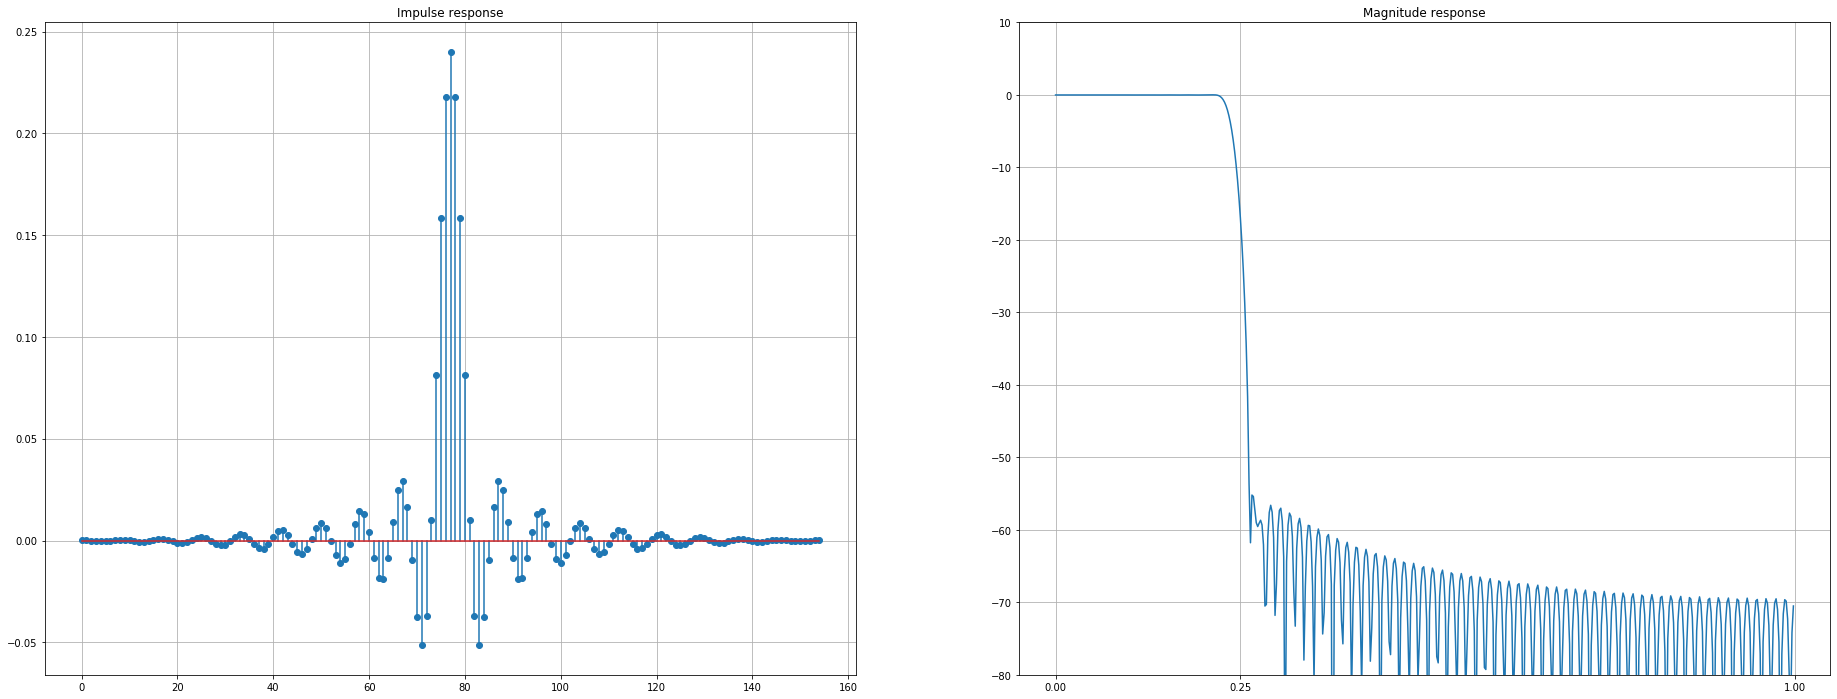

In [8]:
factor = 4  # the downsampling factor
b = signal.firwin(155, 1.0/factor-0.01); a=1  # design the filter
w, H = signal.freqz(b, a) # calculate frequency response

plt.subplot(121)
plt.stem(b)
plt.grid(True); plt.title('Impulse response')

plt.subplot(122)
plt.plot(w/np.pi, 20*np.log10(abs(H)))
plt.grid(True)
plt.xticks([0, 1/factor, 1]);
plt.ylim((-80, 10)); plt.title("Magnitude response");

In [81]:
 def presentAliasingAudio(original, rate, factor):
    down_aliased = original[::factor] # dumb downsampling, no anti-aliasing

    b = signal.firwin(155, 1.0/factor-0.01); a=1  # design the AAF
    lowpass = signal.lfilter(b, a, original)      # apply the AAF
    down_nonaliased = lowpass[::factor]           # perform Downsampling

    display(HTML("Original:"), Audio(data=original, rate=rate))
    display(HTML("With Aliasing:"), Audio(data=down_aliased, rate=rate/factor))
    display(HTML("Without Aliasing:"), Audio(data=down_nonaliased,rate=rate/factor))

In [85]:
Fs = 44100
t = np.arange(0, 10, 1/Fs)
f = 200
data_chirp = np.sin(2*np.pi*f*t*t)
rate_chirp = Fs
presentAliasingAudio(data_chirp, rate_chirp, 10)

In [10]:
presentAliasingAudio(data_chirp, rate_chirp, 10)

In [11]:
voice_path = "Samples\sample 1.wav"
#url_voice = "http://ia800200.us.archive.org/21/items/adventures_of_dog_1101_librivox/adventuresofadog_00_elwes.mp3"
#url_music = "http://www.scientificinvesting.eu/a/Mozart%20-%20Symphony%20n.10%20K.74%20in%20G%20-%201%20Allegro.mp3"
rate_voice, data_voice = loadAudioDIR(voice_path, 40, 10)
#rate_music, data_music = loadAudio(url_music, 40, 10)

In [12]:
# to call this function, the code below needs to be executed before
presentAliasingAudio(data_voice, rate_voice, 6)

In [13]:
presentAliasingAudio(data_music, rate_music, 6)

NameError: name 'data_music' is not defined